# 협업 필터링 추천 시스템(CF:Collaborative Filtering)
협업 필터링 추천시스템은 이전에 사용자 집단별(성별,직업별 등) 추천이 생각만큼 정확한 결과를 내지 못하는 것을 확인했다. 이때, 추천하고 싶은 대상과 비슷한 평가를 내린 사용자들을 기준으로 추천을 하면 어떨까? 라는 idea에서 나온 추천시스템이다. 이는 `취향`을 반영했기 때문에 더 정확한 결과를 도출 할 것이라고 예상한다.

* 이때, 취향이 비슷한 사람을 찾는 방법에는 사용자가 각 Product에 매긴 평가를 기준으로 `상관계수`를 구할 수도 있고, `코사인 유사도`를 구할 수 있는데, 만약에 평가가 0또는 1(클릭을 기준으로 반영가능)로 떨어질 경우에는 `타나모토 계수`와 `자카드 계수`를 사용한다. 
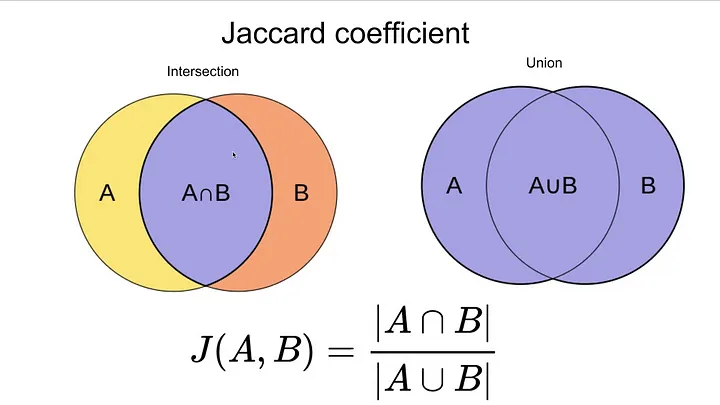

## 기본 CF알고리즘
* **모든 사용자의 유사도를 계산**
* **평가대상 사용자와 다른 사용자간에 유사도 추출**
* **평가대상 사용자가 선택하지 않은 아이템들에 대해서 나머지 사용자들의 예상 평가값을 구한다. 이때 유사도 지표값을 가중치로 해서 평균을 낸다**
* **아이템 중에서 예상 평가값이 가장 높은 N개의 아이템을 추천한다.**

In [3]:
import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
          'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
          'Thriller', 'War', 'Western']
movies = pd.read_csv('./u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기 
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

In [4]:
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [5]:
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [6]:
movies

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [7]:
rating_matrix

movie_id,1,2,3,4,5,6,7,8,9,10,...,1671,1672,1673,1674,1675,1676,1677,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,4.0,3.0,3.0,5.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
# train set의 모든 가능한 사용자 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
print(user_similarity)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
print(user_similarity)

[[1.         0.09698148 0.03301215 ... 0.10782833 0.13570114 0.28949344]
 [0.09698148 1.         0.08424208 ... 0.19833373 0.10800418 0.04921137]
 [0.03301215 0.08424208 1.         ... 0.0270147  0.1132396  0.        ]
 ...
 [0.10782833 0.19833373 0.0270147  ... 1.         0.0297933  0.1016665 ]
 [0.13570114 0.10800418 0.1132396  ... 0.0297933  1.         0.11504475]
 [0.28949344 0.04921137 0.         ... 0.1016665  0.11504475 1.        ]]
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.096981  0.033012  0.068611  0.277589  0.323906  0.325450   
2        0.096981  1.000000  0.084242  0.200160  0.096194  0.201180  0.082589   
3        0.033012  0.084242  1.000000  0.358675  0.000000  0.043387  0.025339   
4        0.068611  0.200160  0.358675  1.000000  0.041533  0.090615  0.061691   
5        0.277589  0.096194  0.000000  0.041533  1.000000  0.228226  0

In [14]:
# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 사용자와 다른 사용자 간의 유사도(user_similarity)
def CF_simple(user_id, movie_id):
    if movie_id in rating_matrix:
        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy() # rating_matrix는 Null로 채워져 있음
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.dropna()
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(CF_simple)

1.0228708762776757

**상관계수를 기준으로 구한 similarity를 사용해서 정확도 구해보기**

In [21]:
tmp_user_similarity = np.transpose(matrix_dummy).corr()
tmp_user_similarity

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.046593,-0.014912,0.037031,0.211521,0.250309,0.219887,0.227738,0.040024,0.160234,...,0.208952,0.045944,0.100794,0.100468,0.050119,0.021572,0.173702,0.081081,0.080228,0.223692
2,0.046593,1.000000,0.062674,0.187003,0.057339,0.162338,0.017444,0.079453,0.175805,0.063165,...,0.078346,0.177611,0.172268,0.374631,0.226356,0.088426,0.097111,0.186114,0.080379,0.007597
3,-0.014912,0.062674,1.000000,0.349494,-0.037990,0.001188,-0.036905,0.025481,0.050492,0.019507,...,-0.014026,-0.018590,0.082203,-0.009697,0.044192,0.000056,0.072775,0.013614,0.089343,-0.038453
4,0.037031,0.187003,0.349494,1.000000,0.015935,0.063330,0.021446,0.205852,0.131081,0.036774,...,0.044365,-0.013337,0.130772,0.084407,0.113137,-0.015130,0.119477,0.123755,0.153303,0.054238
5,0.211521,0.057339,-0.037990,0.015935,1.000000,0.164756,0.170397,0.149575,0.013378,0.085186,...,0.153119,0.052100,0.003823,0.052509,0.055474,0.012122,0.121086,0.071042,0.109551,0.188601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.021572,0.088426,0.000056,-0.015130,0.012122,0.041653,0.016990,0.049599,0.041814,0.012383,...,-0.009254,0.312191,0.199971,0.180216,0.265593,1.000000,0.046476,0.155253,0.013371,0.099850
940,0.173702,0.097111,0.072775,0.119477,0.121086,0.181026,0.146902,0.152863,0.081751,0.212061,...,0.207557,0.074365,0.076131,0.065236,0.094104,0.046476,1.000000,0.113929,0.143733,0.098959
941,0.081081,0.186114,0.013614,0.123755,0.071042,0.122689,0.005411,0.168744,0.139391,0.061090,...,0.026514,0.223154,0.279108,0.084476,0.244780,0.155253,0.113929,1.000000,0.012303,0.079954


In [22]:
# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 사용자와 다른 사용자 간의 유사도(user_similarity)
def tmp_cf_simple(user_id, movie_id):
    if movie_id in rating_matrix:
        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = tmp_user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy() # rating_matrix는 Null로 채워져 있음
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.dropna()
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(tmp_cf_simple)

1.0330759699909555

In [23]:
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 이웃을 고려한 CF
CF알고리즘을 개선할 수 있는 한 가지 방법은 사용자 중에서 유사도가 높은 사용자를 선정해서 **그 사람들의 평점만 가지고 예측을 하는 것이다.** 
이를 위해서는 `유사도가 높다`의 기준을 정해야하는데, 이것에는 두가지 방법이 있다.
1. 이웃의 크기를 K로 미리 정해놓고 상위 Score를 갖는 K명을 선택하는 KNN(K Nearest Neighbors)
2. 유사도의 기준(ex> 상관계수 0.8 이상)을 정해놓고 기준을 충족시키는 사용자를 이웃으로 정하는 Thresholding이다. 

<br>

* Thresholding 방법이 KNN보다 정확하지만 기준을 넘는 사용자가 없다면 추천을 하지 못하는 경우가 발생하기 때문이 일반적으로 KNN이 무난하게 많이 사용된다.

In [24]:
# 모델별 RMSE를 계산하는 함수 
# 이전의 score함수와 neighbor_size를 받는다는 점에서만 달라졌는데
# neighbor_size = 0이면 이전과 같이 전체를 고려해서 예측값을 내게된다.
def score(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [26]:
# Neighbor size를 정해서 예측치를 계산하는 함수 
def cf_knn(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_matrix:
        # 현재 사용자와 다른 사용자 간의 similarity 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현재 영화에 대한 모든 사용자의 rating값 가져오기
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.drop(none_rating_idx)
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:          
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
##### (3) Neighbor size가 지정된 경우
        else:                       
            # 해당 영화를 평가한 사용자가 최소 2명이 되는 경우에만 계산
            if len(sim_scores) > 1: 
                # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))
                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores) # 이 user_idx를 이용해서 ratings를 추출
                # 유사도를 neighbor size만큼 받기
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                # 영화 rating을 neighbor size만큼 받기
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 최종 예측값 계산 
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(cf_knn, neighbor_size=30)

1.0150199967047993

In [50]:
##### (4) 주어진 사용자에 대해 추천받기 
# 전체 데이터로 full matrix와 cosine similarity 구하기 
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
# 전체 데이터셋을 이용해서 추천

def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    # 이미 평가한 영화 확인
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    
    # 이미 평가한 영화는 drop
    items = rating_matrix.loc[user].drop(rated_index)
    # 이미 평가한 영화들을 제외한 인덱스에 대해서
    for item in items.index:
        # 각 영화에 대한 예상평점 계산
        predictions.append(cf_knn(user, item, neighbor_size))                  
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    # 예상평점이 가장 높은 영화 상위 5개 선택
    recommendations = recommendations.sort_values(ascending=False)[:n_items]
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

recommender(user=2, n_items=5, neighbor_size=30) # 2번 user에 대해서 실행

/tmp/ipykernel_481214/1507960589.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  recommendations = recommendations.sort_values(ascending=False)[:n_items]    # 예상평점이 가장 높은 영화 선택


movie_id
919                       Two Bits (1995)
408                           Jack (1996)
147    Ghost and the Darkness, The (1996)
174                         Brazil (1985)
124                     Phenomenon (1996)
Name: title, dtype: object

In [51]:
##### (4) 주어진 사용자에 대해 추천받기 
# 전체 데이터로 full matrix와 cosine similarity 구하기 
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
# 전체 데이터셋을 이용해서 추천

def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    # 이미 평가한 영화 확인
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    
    # 이미 평가한 영화는 drop
    items = rating_matrix.loc[user].drop(rated_index)
    # 이미 평가한 영화들을 제외한 인덱스에 대해서
    for item in items.index:
        # 각 영화에 대한 예상평점 계산
        predictions.append(cf_knn(user, item, neighbor_size))                  
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    # 예상평점이 가장 높은 영화 상위 5개 선택
    recommendations = recommendations.sort_values(ascending=False)[:n_items]
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

recommender(user=2, n_items=5, neighbor_size=15) # 2번 user에 대해서 실행

/tmp/ipykernel_481214/2890312617.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  recommendations = recommendations.sort_values(ascending=False)[:n_items]


movie_id
204                     Patton (1970)
235               Citizen Ruth (1996)
475      First Wives Club, The (1996)
663               Paris, Texas (1984)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

## 최적의 이웃의 크기를 찾기
우리는 이웃의 크기마다 값이 변하는 것을 확인할 수 있다. 그렇다면 어떤 크기의 이웃의 크기가 가장 좋을까? 
* 이웃의 크기가 클경우: 극단적으로 이웃의 크기가 전체 데이터라고 한다면 전체 데이터에 대해서 가중평균을 하는 것과 같을 것이다. 이는 전체 사람의 성향을 반영했으므로 그렇게 좋은 예측이 아니다.
* 이웃의 크기가 작을경우: 이웃의 크기가 나와 성향이 매우 비슷한 하나의 사람으로 한다면 이는 Over Fitting이 되어 예측치의 신뢰성이 낮아지게 된다.
* 따라서 얼마의 크기가 최적의 크기인지 알기 위해서는 경험적으로(empirically) 알 수 밖에 없다. 이를 위해서 이웃의 크기를 10씩 늘려보고 그 이후에 세밀하게 1씩 변화시키면서 결과를 보면 된다.

In [52]:
# train set으로 full matrix와 cosine similarity 구하기 
rating_matrix = x_train.pivot_table(values='rating', index='user_id', columns='movie_id')
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
for neighbor_size in [10, 20, 30, 40, 50, 60]:
    print("Neighbor size = %d : RMSE = %.4f" % (neighbor_size, score(cf_knn, neighbor_size)))

Neighbor size = 10 : RMSE = 1.6255
Neighbor size = 20 : RMSE = 1.5122
Neighbor size = 30 : RMSE = 1.4292
Neighbor size = 40 : RMSE = 1.3709
Neighbor size = 50 : RMSE = 1.3236
Neighbor size = 60 : RMSE = 1.2870


## 사용자의 평가경향을 고려한 CF
Collaborative Filtering의 성능향상을 위해서는 `사용자의 평가경형(user bias)`을 고려하는 것이 도움이 된다. 이것이 무슨 말이냐 하면 <br>

예를 들어 나는 점수를 주는데 좀 박한 편이라서 평점평균이 5점 만점중 2점이고 내 친구는 점수를 잘 주는 편이라 평점평균이 4.5점이라고 해보자. 이때 어떤 영화에 대해서 나와 내친구 둘다 3점을 줬다고 했을때, 이는 같은 점수임에도 상당히 다른 의미를 갖고 있음을 알 수 있다.

이렇게 사용자의 평점 평균을 고려하지 않는 방식이 현재의 방식이고 현재의 방식을 식으로써 나타내면 다음과 같다.
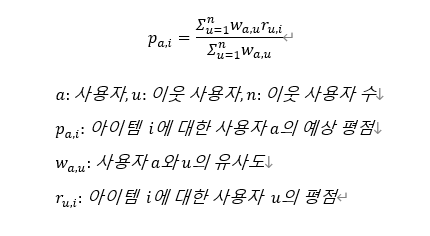

따라서 이러한 경우 만약 나의 영화 예상 평점이 4점으로 나왔다면 친구와 나의 평점차인 2.5를 빼서
4.0-2.5 = 1.5를 예상 평점으로 사용하는 것이 합리적 일 것이다.
이를 반영하여 수정한 식은 다음과 같다.
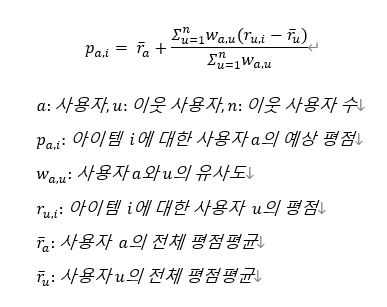

위의 식을 말로써 풀어쓰면 다음과 같다.
* 나의 이웃을 정한후 나의 이웃의 영화 i에 대한 `평점편차`를 구한다.
* 편차를 `가중합` 한 이후
* 이를 나의 평균에 더한다.

**또한 예측값을 구할 수 없는 경우에 지금까지는 3.0을 할당했지만 이번엔 평점평균으로 대체한다.**

In [60]:
# train 데이터의 각 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
# DataFrame의 .T속성을 사용하여 Transpose를 시켰다. 컬럼: user_id, 행: movie_id
# DataFrame과 벡터를 빼는 것이기 때문에 벡터가 DF의 각 Sample에 대응된다.
rating_bias = (rating_matrix.T - rating_mean).T

def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        # 현 user와 다른 사용자 간의 유사도 가져오기
        sim_scores = user_similarity[user_id].copy()
        # 현 movie의 평점편차 가져오기
        movie_ratings = rating_bias[movie_id].copy()
        # 현 movie에 대한 rating이 없는 사용자 삭제
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:
            # 편차로 예측값(편차 예측값) 계산
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            # 편차 예측값에 현 사용자의 평균 더하기
            prediction = prediction + rating_mean[user_id]
##### (3) Neighbor size가 지정된 경우            
        else:
            # 해당 영화를 평가한 사용자가 최소 2명이 되는 경우에만 계산            
            if len(sim_scores) > 1:
                # 지정된 neighbor size 값과 해당 영화를 평가한 총사용자 수 중 작은 것으로 결정
                neighbor_size = min(neighbor_size, len(sim_scores))
                # array로 바꾸기 (argsort를 사용하기 위함)
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores)
                # 유사도와 rating을 neighbor size만큼 받기
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 편차로 예측치 계산
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                # 예측값에 현 사용자의 평균 더하기
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

score(CF_knn_bias, 30)

0.9489212110442304

In [70]:
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
# 전체 데이터셋을 이용해서 추천

def recommender(user, n_items=10, neighbor_size=20):
    # 현재 사용자의 모든 아이템에 대한 예상 평점 계산
    predictions = []
    # 이미 평가한 영화 확인
    rated_index = rating_matrix.loc[user][rating_matrix.loc[user] > 0].index    
    # 이미 평가한 영화는 drop
    items = rating_matrix.loc[user].drop(rated_index)
    # 이미 평가한 영화들을 제외한 인덱스에 대해서
    # user가 이미 평가한 영화들은 제외했기 때문에 user 스스로의 영향은 제거된다.
    for item in items.index:
        # 각 영화에 대한 예상평점 계산
        predictions.append(cf_knn(user, item, neighbor_size))                 
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    # 예상평점이 가장 높은 영화 상위 5개 선택
    recommendations = recommendations.sort_values(ascending=False)[:n_items]
    recommended_items = movies.loc[recommendations.index]['title']
    return recommended_items

recommender(user=2, n_items=5, neighbor_size=15) # 2번 user에 대해서 실행

/tmp/ipykernel_481214/2150819587.py:22: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  recommendations = recommendations.sort_values(ascending=False)[:n_items]


movie_id
204                     Patton (1970)
235               Citizen Ruth (1996)
475      First Wives Club, The (1996)
663               Paris, Texas (1984)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object

## 그 외의 CF 정확도 개선 방안
* 다음과 같은 상황을 생각해 볼 수 있다. 사용자 A에 대해 추천할때, 어떤 사용자는 사용자 A와 공통으로 평가한 아이템이 10개인 경우가 있고 또 다른 사용자는 사용자 A와 공통으로 평가한 아이템이 2개인 경우가 있다. 이경우 사용자 A와 이 두사용자 간의 유사도가 비슷해도 신뢰도는 당연하게 10개가 모두 비슷한 사용자가 더 높다고 할 수 있다. 따라서 신뢰도가 더 높은 사용자에 대해서 가중을 주고자 하는 건데, 가중치를 같이 평가한 아이템의 개수로 직접 건드는 것은 예측값이 매우 민감하기 때문에 오히려 예측값을 이상하게 만들 수 있기 때문에, 일정 개수 이상을 같이 평가한 사용자만을 예측치 계산에 사용하는 것으로 개선할 수 있다.

## IBCF(Item Based Content Filtering)
여태까지는 User간의 Similarity를 기반으로 한 UBCF(User Based Content Filtering)을 사용하여서 추천을 진행했다.<br>
여기서는 Item간의 Similarity를 기반으로 한 IBCF(Item Based Content Filtering)을 사용하여서 추천을 진행해볼 것이다. IBCF는 다음과 같은 Process로 진행 된다.
<HR></HR>
* **추천 대상 사용자가 평가하지 않은 아이템에 대한 점수를 구하는데**
* **사용자들이 Item에 대해서 평가한 Item 점수 벡터를 이용해서 아이템 간의 Similarity를 구한다.**
* **이중 평가 대상 아이템의 Similarity를 추출한다.**
* **사용자가 평가를 진행했던 아이템 점수들과 위에서 구한 Similarity 벡터를 이용해서 dot product를 계산한다.**
* **위의 단계들을 반복해 평가하지 않은 아이템에 대한 예측 Score를 구한 이후 추천을 진행한다.**
<HR></HR>

### IBCF(Item Based Content Filtering) vs UBCF(User Based Content Filtering)
<br>
<font color = blue>
    
* UBCF는 개인간의 유사도를 구한후 유사도가 높은 사람들의 평가 데이터를 기반으로 계산을 진행하고<br>IBCF는 아이템간의 유사도를 구한후 자기 자신의 평가 데이터를 기반으로 계산을 진행하기 때문에<br>UBCF는 데이터가 많을 경우 정확한 추천이 가능하다는 장점이 있고, IBCF는 더 빠른 추천을 한다.
* UBCF는 데이터가 변한다면 업데이트를 해야 하지만 IBCF는 데이터가 조금 바뀌어도 추천 결과에는 영향이 크지 않기 때문에 업데이트를 자주 하지 않아도 된다.
</font>


* **아마존과 같이 대규모 데이터를 다뤄야 하는 상업용 사이트에서는 IBCF를 기반한 알고리즘이 사용된다.**


* 3장 초반 설정과 비슷하다.

In [74]:

import numpy as np
import pandas as pd

# 데이터 읽어 오기 
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./u.user', sep='|', names=u_cols, encoding='latin-1')
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
          'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
          'Thriller', 'War', 'Western']
movies = pd.read_csv('./u.item', sep='|', names=i_cols, encoding='latin-1')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./u.data', sep='\t', names=r_cols, encoding='latin-1')

# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

# train, test 데이터 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

# 정확도(RMSE)를 계산하는 함수 
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

# train 데이터로 Full matrix 구하기  
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')


In [75]:
 # train set의 모든 가능한 아이템 pair의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, columns=rating_matrix_t.index)

# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 아이템과 다른 아이템 간의 유사도(item_similarity)
def CF_IBCF(user_id, movie_id):
    if movie_id in item_similarity:      # 현재 영화가 train set에 있는지 확인
        # 현재 영화와 다른 영화의 similarity 값 가져오기
        sim_scores = item_similarity[movie_id]
        # 현 사용자의 모든 rating 값 가져오기
        user_rating = rating_matrix_t[user_id]
        # 사용자가 평가하지 않은 영화 index 가져오기
        non_rating_idx = user_rating[user_rating.isnull()].index
        # 사용자가 평가하지 않은 영화 제거
        user_rating = user_rating.dropna()
        # 사용자가 평가하지 않은 영화의 similarity 값 제거
        sim_scores = sim_scores.drop(non_rating_idx)
        # 현 영화에 대한 예상 rating 계산, 가중치는 현 영화와 사용자가 평가한 영화의 유사도
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산
score(CF_IBCF)


1.0066949865785713

## CF의 평가
CF의 평가가 점수(float)형태라면 MSE나 RMSE를 사용하면 된다.<br>
하지만 현실의 많은 경우에는 데이터가 구매를 했냐 안했냐의 2진 평가로 나뉜다.<br>
예를 들어서 사용자에게 추천 아이템을 제시한 경우 특정 아티멩을 클릭했는가(1), 안했는가(0)와 같은 이진값 형태로 데이터가 수집되는 경우가 많다.<br>
이러한 경우에 추천 시스템의 성능을 평가하는 중요한 두 가지 측정지표는 정밀도(precision)과 재현율(recall)이다.<br>
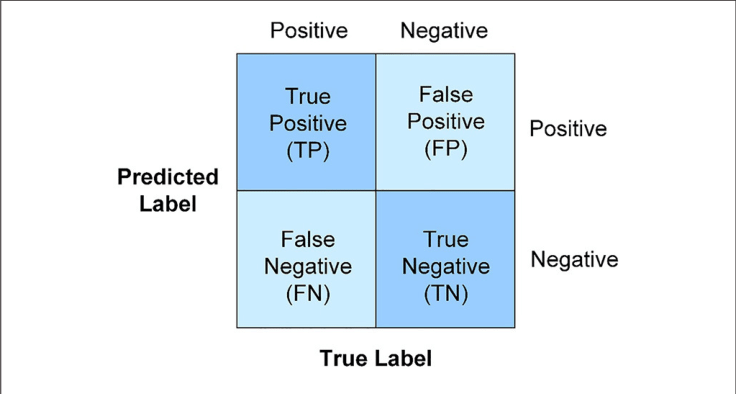
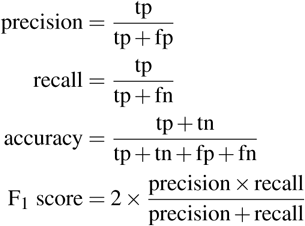

위의 설명을 우리의 Task에 맞춰서 고치면 다음과 같다.
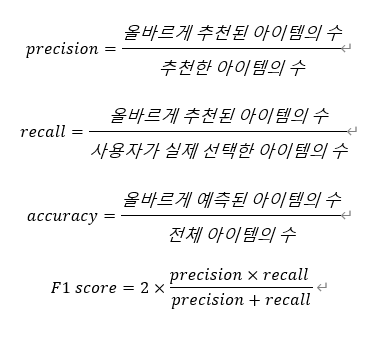
정밀도와 재현율은 서로 Trade-off관계에 있기 때문에 이를 보완한 F1-Score가 많이 사용된다.


또한 다음과 같은 기준을 사용하기도 한다.
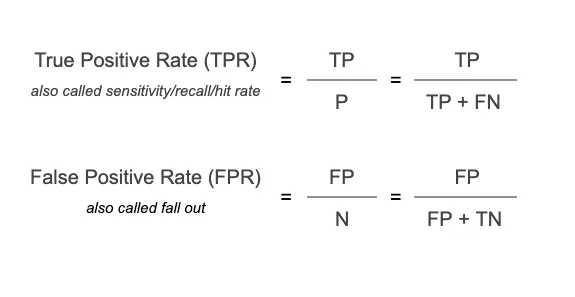
* TPR은 Recall 즉, 올바르게 추천한 아이템 개수/사용자가 실제 선택한 아이템 갯수
* FPR은 잘못 추천된 아이템의 비율 잘못 추천한 아이템/ 사용자가 선택하지 않은 아이템 갯수

* 현실에서는 아이템의 갯수는 엄청 많고 그만큼 사용자가 보지 않은 아이템도 엄청나게 많아서 내가 추천하지 않았는데 사용자가 실제로 선택하지 않은 것에 해당하는 TN의 값이 엄청나게 클 것이다. 이때문에, FN이 들어간 FPR은 정확한 측정이 어렵다. 따라서 아이템이 많은 경우에는 현실적으로 사용가능한 지표는 재현율과 정밀도 이다.